# DESCRIPCION EJERCICIO

Analisis que nos piden:

**exploratorio**:

SUBE:

1.   Calcular viajes totales por tipo de linea (nacional, regional,provincial), tipo tranporte (tren, subte, etc.) y provincia
1.   Filtrar area AMBA
1.   analizar cuales son las lineas de colectivo donde mas se viaja, hacer un pareto de lineas
1.   Analizar viajes por semana para area AMBA por tipo de transporte. Hay estacionalidad?

Trafico:

1.   analizar estacionalidad total del trafico total por dia, hora hay mucha distorsion?
1.   idem arriba, pero abriendo por radar, hay diferencias ?
1.  Hay diferencias por sentido para el mismo radar?

CRUCE:
1.   hay correlacion entre el total de viajes del amba por dia y el trafico reportado por el radar por dia?

**predictivo**
1.  Generar un pronostico de viajes para el total de AMBA para lo que resta de 2023
1.  Generar un pronostico para una linea a eleccion

** adicional **
1.  Si se animan - comparar estacionalidad para lineas 

# IMPORTS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## auxiliares

In [ ]:
!pip install shapely
!pip install geopandas
!pip install contextily
!pip install sweetviz
!pip install folium

In [2]:
# Georeferenciacion
import geopandas as gpd # bdd georeferenciadas
import contextily as cx # para mostrar mapas
import folium # para mostrar mapas interactivos
import shapely # para trabajar con formas (poligonos, puntos, etc.)

# Otros
import sweetviz as sv # para descriptores rapidos

# DATOS PRINCIPALES

## urls

In [3]:
# el de sube tiene 4 archivos: 2020-2021-2022-2023
# dejamos un "comodin" en el año usando {} y lo rellenamos usando .format mas tarde
url_sube = 'https://archivos-datos.transporte.gob.ar/upload/Dat_Ab_Usos/dat-ab-usos-{}.csv'

url_radares = 'https://cdn.buenosaires.gob.ar/datosabiertos/datasets/transporte-y-obras-publicas/flujo-vehicular-anillo-digital/dataset_flujo_vehicular.csv'

## datos SUBE

### leer

In [4]:
lista_df = []

for year in range(2020, 2024):
  url = url_sube.format(year)
  print('Leyendo datos de', url)

  df_part = pd.read_csv(url)
  print('Datos leidos. Filas:', len(df_part))

  lista_df.append(df_part)

df_sube = pd.concat(lista_df, axis=0)

Leyendo datos de https://archivos-datos.transporte.gob.ar/upload/Dat_Ab_Usos/dat-ab-usos-2020.csv
Datos leidos. Filas: 356628
Leyendo datos de https://archivos-datos.transporte.gob.ar/upload/Dat_Ab_Usos/dat-ab-usos-2021.csv
Datos leidos. Filas: 410644
Leyendo datos de https://archivos-datos.transporte.gob.ar/upload/Dat_Ab_Usos/dat-ab-usos-2022.csv
Datos leidos. Filas: 439337
Leyendo datos de https://archivos-datos.transporte.gob.ar/upload/Dat_Ab_Usos/dat-ab-usos-2023.csv
Datos leidos. Filas: 180857


In [5]:
# descripcion de los datos
print('columnas:', df_sube.columns)
print('Filas:', len(df_sube))
print('Sample:')
print(df_sube.sample(2))

columnas: Index(['DIA_TRANSPORTE', 'NOMBRE_EMPRESA', 'LINEA', 'AMBA', 'TIPO_TRANSPORTE',
       'JURISDICCION', 'PROVINCIA', 'MUNICIPIO', 'CANTIDAD',
       'DATO_PRELIMINAR'],
      dtype='object')
Filas: 1387466
Sample:
       DIA_TRANSPORTE                   NOMBRE_EMPRESA           LINEA AMBA  \
129129     2021-05-01  SAN VICENTE S.A. DE TRANSPORTES  BSAS_LINEA_079   SI   
289784     2020-10-25        LIBERTADOR SAN MARTIN SAT  BSAS_LINEA_327   SI   

       TIPO_TRANSPORTE JURISDICCION     PROVINCIA MUNICIPIO  CANTIDAD  \
129129       COLECTIVO     NACIONAL            JN        SD      4699   
289784       COLECTIVO   PROVINCIAL  BUENOS AIRES        SN      2541   

       DATO_PRELIMINAR  
129129              NO  
289784              NO  


### limpiar

In [6]:
# columnas a minusc
df_sube = df_sube.rename(columns=str.lower)

# agregar un AMBA boolean
df_sube['es_amba'] = df_sube['amba'] == 'SI'

df_sube['fecha'] = pd.to_datetime(df_sube['dia_transporte'])

print(df_sube.columns)
df_sube.head()

Index(['dia_transporte', 'nombre_empresa', 'linea', 'amba', 'tipo_transporte',
       'jurisdiccion', 'provincia', 'municipio', 'cantidad', 'dato_preliminar',
       'es_amba', 'fecha'],
      dtype='object')


,dia_transporte,nombre_empresa,linea,amba,tipo_transporte,jurisdiccion,provincia,municipio,cantidad,dato_preliminar,es_amba,fecha
0,2020-01-01,EMPRESA BATAN S.A.,BS_AS_LINEA 715M,NO,COLECTIVO,MUNICIPAL,BUENOS AIRES,GENERAL PUEYRREDON,2154,NO,False,2020-01-01
1,2020-01-01,COMPAÑIA DE TRANSPORTE VECINAL S.A.,BS_AS_LINEA_326,SI,COLECTIVO,PROVINCIAL,BUENOS AIRES,SN,1492,NO,True,2020-01-01
2,2020-01-01,EMPRESA DE TRANSPORTE PERALTA RAMOS SACI,BS_AS_LINEA_512,NO,COLECTIVO,MUNICIPAL,BUENOS AIRES,GENERAL PUEYRREDON,1889,NO,False,2020-01-01
3,2020-01-01,AUTOBUSES BUENOS AIRES S.R.L. – TRANSPORTE LAR...,BS_AS_LINEA_514,SI,COLECTIVO,MUNICIPAL,BUENOS AIRES,ALMIRANTE BROWN,4669,NO,True,2020-01-01
4,2020-01-01,EL URBANO SRL,BS_AS_LINEA_522,SI,COLECTIVO,MUNICIPAL,BUENOS AIRES,LANUS,187,NO,True,2020-01-01


### Feriados

In [50]:
holiday_dates = [
    '2020-01-01',  # New Year's Day
    '2020-02-24',  # Carnival
    '2020-02-25',  # Carnival
    '2020-03-24',  # Day of Remembrance for Truth and Justice
    '2020-04-02',  # Malvinas Day
    '2020-04-09',  # Holy Thursday
    '2020-04-10',  # Good Friday
    '2020-05-01',  # Labor Day
    '2020-05-25',  # National Day
    '2020-06-15',  # Flag Day
    '2020-06-20',  # National Flag Day
    '2020-07-09',  # Independence Day
    '2020-12-08',  # Immaculate Conception Day
    '2020-12-25',  # Christmas Day
    '2021-01-01',  # New Year's Day
    '2021-02-15',  # Carnival
    '2021-02-16',  # Carnival
    '2021-03-24',  # Day of Remembrance for Truth and Justice
    '2021-04-02',  # Malvinas Day
    '2021-04-09',  # Holy Thursday
    '2021-04-10',  # Good Friday
    '2021-05-01',  # Labor Day
    '2021-05-25',  # National Day
    '2021-06-21',  # National Flag Day
    '2021-07-09',  # Independence Day
    '2021-12-08',  # Immaculate Conception Day
    '2021-12-25',  # Christmas Day
    '2022-01-01',  # New Year's Day
    '2022-02-28',  # Carnival
    '2022-03-24',  # Day of Remembrance for Truth and Justice
    '2022-04-02',  # Malvinas Day
    '2022-04-15',  # Good Friday
    '2022-05-01',  # Labor Day
    '2022-05-25',  # National Day
    '2022-06-20',  # National Flag Day
    '2022-07-09',  # Independence Day
    '2022-12-08',  # Immaculate Conception Day
    '2022-12-25',  # Christmas Day
    '2023-01-01',  # New Year's Day
    '2023-02-20',  # Carnival
    '2023-02-21',  # Carnival
    '2023-03-24',  # Day of Remembrance for Truth and Justice
    '2023-04-02',  # Malvinas Day
    '2023-04-07',  # Good Friday
    '2023-05-01',  # Labor Day
    '2023-05-25',  # National Day
    '2023-06-19',  # National Flag Day
    '2023-07-09',  # Independence Day
    '2023-12-08',  # Immaculate Con
]

In [51]:
holiday_dates = pd.to_datetime(pd.Series(holiday_dates))
holiday_dates.head(2)

0   2020-01-01
1   2020-02-24
dtype: datetime64[ns]

In [52]:
df_sube['es_feriado'] = df_sube['fecha'].isin(holiday_dates)

## datos radares

### leer

In [257]:
url = url_radares
df_radares_raw = pd.read_csv(url)

print('Filas:', len(df_radares_raw))
print('Columnas:', df_radares_raw.columns)

df_radares_raw.head()

Filas: 189814
Columnas: Index(['CODIGO_LOCACION', 'HORA', 'CANTIDAD', 'SENTIDO', 'LATITUD',
       'LONGITUD'],
      dtype='object')


,CODIGO_LOCACION,HORA,CANTIDAD,SENTIDO,LATITUD,LONGITUD
0,48Q3CJ00+,31MAR2020:15:00:00,729,Interna,-34.588796,-58.381520
1,48Q3CJ00+,31MAR2020:15:00:00,447,Egreso,-34.588796,-58.381520
2,48Q39G00+,31MAR2020:15:00:00,175,Interna,-34.633299,-58.468594
3,48Q39G00+,31MAR2020:15:00:00,1186,Egreso,-34.633299,-58.468594
4,48Q3CH00+,31MAR2020:15:00:00,35,Egreso,-34.579632,-58.427733


### limpiar

In [258]:
# columnas a minusc
df_radares = df_radares_raw.rename(columns=str.lower)

# sacar fecha y hora
df_radares['timestamp'] = pd.to_datetime(df_radares['hora'], format='%d%b%Y:%H:%M:%S')
df_radares['hora'] = df_radares['timestamp'].dt.hour
df_radares['fecha'] = df_radares['timestamp'].dt.date

print(df_radares.columns)
df_radares.head()

Index(['codigo_locacion', 'hora', 'cantidad', 'sentido', 'latitud', 'longitud',
       'timestamp', 'fecha'],
      dtype='object')


,codigo_locacion,hora,cantidad,sentido,latitud,longitud,timestamp,fecha
0,48Q3CJ00+,15,729,Interna,-34.588796,-58.381520,2020-03-31 15:00:00,2020-03-31
1,48Q3CJ00+,15,447,Egreso,-34.588796,-58.381520,2020-03-31 15:00:00,2020-03-31
2,48Q39G00+,15,175,Interna,-34.633299,-58.468594,2020-03-31 15:00:00,2020-03-31
3,48Q39G00+,15,1186,Egreso,-34.633299,-58.468594,2020-03-31 15:00:00,2020-03-31
4,48Q3CH00+,15,35,Egreso,-34.579632,-58.427733,2020-03-31 15:00:00,2020-03-31


### geolocalizar

In [259]:
#geolocalizar
x, y = df_radares.longitud, df_radares.latitud
crs = "EPSG:4326" # coordenadas de referencia en WGS84

df_radares = gpd.GeoDataFrame(df_radares, geometry=gpd.points_from_xy(x, y), crs=crs)

# Analisis 1

## pareto

In [211]:
out = df_sube[df_sube.es_amba & (df_sube['tipo_transporte'] == 'TREN')].groupby('linea')['cantidad'].mean()
out.sort_values(ascending=False)

linea
FFCC ROCA                     260871.940081
FFCC SAR                      128611.698785
FFCC_SANM                      55667.621862
FFCC_BELGRANO_NORTE            54446.784615
FCC MITRE_TIGRE                42532.440032
FFCC URQUIZA                   36011.531174
FFCC_BELG_SUR                  30972.333603
FFCC_SUAREZ                    28153.140081
FFCC SAR  MERLO - LOBOS         1653.521987
FFCC_TREN_COSTA                 1505.030769
FFCC_ROCA_UNIVERSITARIO          588.323155
FFCC_MITRE                       407.954173
FFCC_ROCA_KORN-CHASCOMUS         304.310619
FFCC_MITRE_ZARATE                154.874155
FFCC_ROCA_CAÑUELAS-MONTE          66.749046
FFCC_ROCA_CAÑUELAS-LOBOS          56.814218
FFCC_MITRE_CAPILLA                29.828107
FFCC SAR MORENO - MERCEDES        25.639193
Name: cantidad, dtype: float64

## estacionalidad 

In [219]:
g = df_sube[df_sube.es_amba].groupby(['fecha', 'tipo_transporte'])['cantidad'].mean().reset_index()
g['dia_semana'] = g['fecha'].dt.weekday
g.head(5)

,fecha,tipo_transporte,cantidad,dia_semana
0,2020-01-01,COLECTIVO,4552.501370,2
1,2020-01-01,SUBTE,14744.857143,2
2,2020-01-01,TREN,9188.000000,2
3,2020-01-02,COLECTIVO,20110.534211,3
4,2020-01-02,SUBTE,125274.142857,3


<Axes: xlabel='fecha', ylabel='cantidad'>

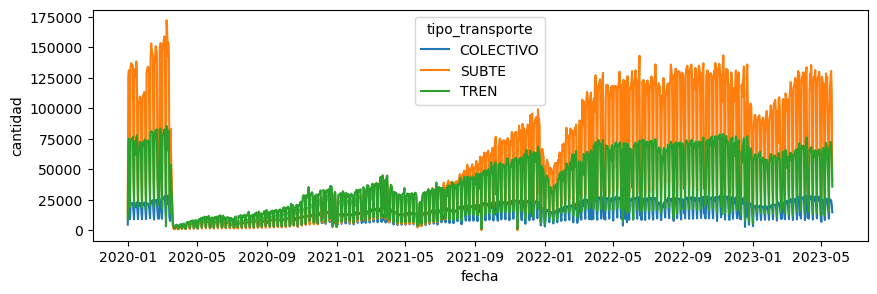

In [213]:
fig, ax = plt.subplots(figsize=(10,3))
sns.lineplot(g, ax=ax, x='fecha', hue='tipo_transporte', y='cantidad')

In [205]:
# pivot por dia de la semana y tipo de transporte
g.pivot_table(index='tipo_transporte', columns='dia_semana', aggfunc='sum', values='cantidad').applymap('{:,.0f}'.format)

dia_semana,0,1,2,3,4,5,6
tipo_transporte,,,,,,,
COLECTIVO,"1,108,304,992","1,191,380,757","1,204,606,967","1,213,113,755","1,186,676,284","801,415,279","435,755,065"
SUBTE,"81,195,115","88,526,903","89,630,643","92,105,504","85,773,943","44,224,948","22,760,299"
TREN,"129,335,465","136,922,756","140,026,112","141,285,896","135,397,970","78,896,689","30,681,411"


<Axes: xlabel='fecha', ylabel='cantidad'>

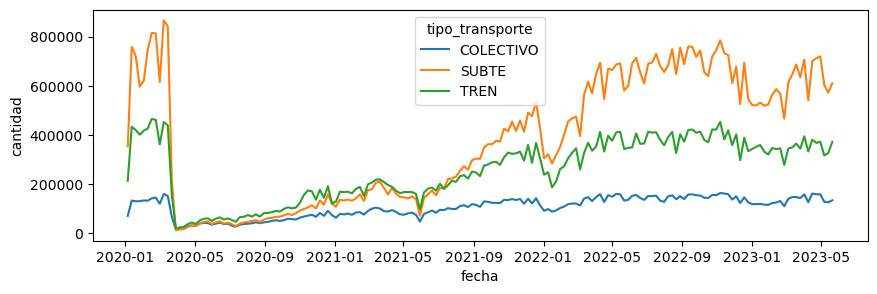

In [220]:
# agrupamos por semana para eliminar la estacionalidad del dia de la semana
g2 = g.groupby([pd.Grouper(key='fecha', freq='W'), 'tipo_transporte'])['cantidad'].sum().reset_index()

fig, ax = plt.subplots(figsize=(10,3))
sns.lineplot(g2, ax=ax, x='fecha', hue='tipo_transporte', y='cantidad')

## radares

<Axes: xlabel='fecha', ylabel='cantidad'>

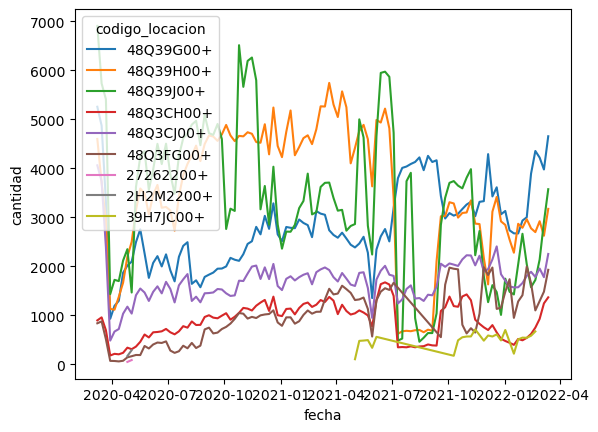

In [256]:
out = df_radares.groupby([pd.Grouper(key='fecha', freq='W'), 'codigo_locacion'])['cantidad'].mean().reset_index()
sns.lineplot(out, y='cantidad', x='fecha', hue='codigo_locacion')

In [269]:
pd.Timestamp.now().weekday()

0

<Axes: xlabel='hora', ylabel='weekday'>

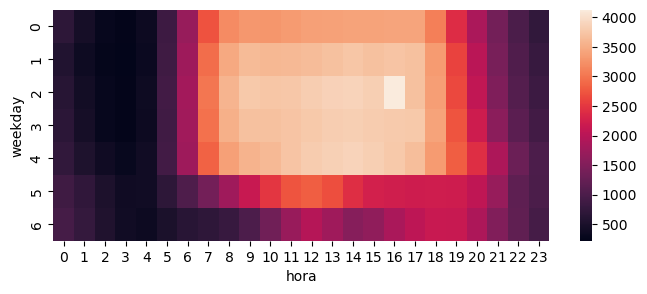

In [270]:
out = df_radares.assign(weekday=df_radares['timestamp'].dt.weekday
                       ).pivot_table(index='weekday', columns='hora', values='cantidad', aggfunc='mean')
fig, ax = plt.subplots(figsize=(8,3))
sns.heatmap(out, ax=ax)

# Datos Secundarios

## urls

In [ ]:
url_barrios = 'https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-educacion/barrios/barrios.geojson'

url_rutas = 'https://cdn.buenosaires.gob.ar/datosabiertos/datasets/transporte-y-obras-publicas/colectivos-recorridos/recorrido-colectivos.csv'
url_paradas = 'https://cdn.buenosaires.gob.ar/datosabiertos/datasets/transporte-y-obras-publicas/colectivos-paradas/paradas-de-colectivo.csv'

## datos barrios CABA

### leer

In [53]:
# notar que esto ya esta geolocalizado, porque es un geojson
url = url_barrios
df_barrios_raw = gpd.read_file(url).explode()
df_barrios_raw.crs="EPSG:4326"

print('Filas:', len(df_barrios_raw))
print('Columnas:', df_barrios_raw.columns)



Filas: 48
Columnas: Index(['BARRIO', 'COMUNA', 'PERIMETRO', 'AREA', 'OBJETO', 'geometry'], dtype='object')


C:\Users\MStainoh\AppData\Local\Temp\ipykernel_20256\623128086.py:3: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  df_barrios = gpd.read_file(url).explode()


### limpiar

In [54]:
# columnas a minusc
df_barrios = df_barrios_raw.rename(columns=str.lower)
df_barrios.head()

,,barrio,comuna,perimetro,area,objeto,geometry
0,0,CHACARITA,15.0,7724.852955,3.115707e+06,BARRIO,"POLYGON ((-58.45282 -34.59599, -58.45366 -34.5..."
1,0,PATERNAL,15.0,7087.513295,2.229829e+06,BARRIO,"POLYGON ((-58.46558 -34.59656, -58.46562 -34.5..."
2,0,VILLA CRESPO,15.0,8131.857075,3.615978e+06,BARRIO,"POLYGON ((-58.42375 -34.59783, -58.42495 -34.5..."
3,0,VILLA DEL PARQUE,11.0,7705.389797,3.399596e+06,BARRIO,"POLYGON ((-58.49461 -34.61487, -58.49479 -34.6..."
4,0,ALMAGRO,5.0,8537.901368,4.050752e+06,BARRIO,"POLYGON ((-58.41287 -34.61412, -58.41282 -34.6..."


### auxiliares

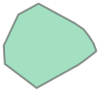

In [55]:
# generamos un poligono de CABA juntando aplicando un convex_hull a la union de los barrios
poligono_caba = df_barrios.unary_union.convex_hull
poligono_caba

## Datos paradas

### leer

In [97]:
df_paradas_raw = gpd.read_file(url_paradas)
df_paradas_raw.crs="EPSG:4326"

print('Filas:', len(df_paradas_raw))
print('Columnas:', df_paradas_raw.columns)
df_paradas_raw.head(2)

Filas: 6846
Columnas: Index(['WKT', 'ID', 'CALLE', 'ALT', 'coord_X', 'coord_Y', 'L1', 'l1_sen', 'L2',
       'l2_sen', 'L3', 'l3_sen', 'field_12', 'L4', 'l4_sen', 'L5', 'l5_sen',
       'L6', 'l6_sen', 'field_19', 'field_20', 'field_21', 'field_22',
       'field_23', 'field_24', 'geometry'],
      dtype='object')


,WKT,ID,CALLE,ALT,coord_X,coord_Y,L1,l1_sen,L2,l2_sen,...,l5_sen,L6,l6_sen,field_19,field_20,field_21,field_22,field_23,field_24,geometry
0,POINT (-58.4517506 -34.5580203),5163,11 DE SEPTIEMBRE DE 1888,2189,-58.4517506,-34.5580203,15,I,29,I,...,,,,,,,,,,POINT (-58.45175 -34.55802)
1,POINT (-58.467365 -34.537759),8851,11 DE SEPTIEMBRE DE 1888,4650,-58.467365,-34.537759,28,I,117,I,...,,,,,,,,,,POINT (-58.46737 -34.53776)


### limpiar

In [233]:
# cambiar nombre columnas
df_paradas = df_paradas_raw.rename(columns=str.lower).rename(
    columns={'coord_x': 'longitud', 'coord_y': 'latitud'})

In [234]:
# juntar columnas de linea y sentido
id_vars = ['id', 'calle', 'alt', 'latitud', 'longitud', 'geometry']
value_vars = []
for i in range(1, 7):
    new_col_name = 'col_{}'.format(i)
    df_paradas[new_col_name] = df_paradas[['l{}'.format(i), 'l{}_sen'.format(i)]].apply(tuple, axis=1)
    value_vars.append(new_col_name)

print(df_paradas[value_vars].head())

      col_1     col_2    col_3 col_4 col_5 col_6
0   (15, I)   (29, I)  (42, I)  (, )  (, )  (, )
1   (28, I)  (117, I)     (, )  (, )  (, )  (, )
2  (127, I)      (, )     (, )  (, )  (, )  (, )
3    (9, I)   (28, I)     (, )  (, )  (, )  (, )
4   (91, I)   (90, V)     (, )  (, )  (, )  (, )


In [235]:
# expandir filas
df_paradas = df_paradas.melt(id_vars=id_vars, value_vars=value_vars, value_name='linea_sentido', var_name='original_column')

# tomar numero de linea y sentido. Para los campos vacios, poner un 0
df_paradas['linea'] = pd.to_numeric(df_paradas['linea_sentido'].apply(lambda x: x[0]).str.strip(), errors='coerce').fillna(0).astype(int)
df_paradas['sentido'] = df_paradas['linea_sentido'].apply(lambda x: x[1]).str.strip()

df_paradas.head()

,id,calle,alt,latitud,longitud,geometry,original_column,linea_sentido,linea,sentido
0,5163,11 DE SEPTIEMBRE DE 1888,2189,-34.5580203,-58.4517506,POINT (-58.45175 -34.55802),col_1,"(15, I)",15,I
1,8851,11 DE SEPTIEMBRE DE 1888,4650,-34.537759,-58.467365,POINT (-58.46737 -34.53776),col_1,"(28, I)",28,I
2,2765,14 DE JULIO,711,-34.5848337,-58.4620871,POINT (-58.46209 -34.58483),col_1,"(127, I)",127,I
3,5466,15 DE NOVIEMBRE DE 1889,1185,-34.6307854,-58.3822511,POINT (-58.38225 -34.63079),col_1,"(9, I)",9,I
4,6465,15 DE NOVIEMBRE DE 1889,1287,-34.6309409,-58.3839737,POINT (-58.38397 -34.63094),col_1,"(91, I)",91,I


In [236]:
print(df_paradas['sentido'].value_counts())
print()
print(df_paradas['linea'].unique())

          30536
I          5396
V          5111
v            10
I-V          10
i             5
I -V          2
(b) I         2
(a) I         1
(ac) V        1
60            1
I (NO)        1
Name: sentido, dtype: int64

[ 15  28 127   9  91  95  25  65 134  50 168 133  31  32  56   5  75   6
 164   4  46 114 101  86  42 124  92 145  84 135  55 172 102 109  63   7
 128 188  90  70 110  47 129 107  74 106  53  20 111 103 115   0  29 152
  33  64  76 108 113 140 151  93 176  44  19  17  59 118 150  37  24 105
  71  39  23 132 195 143  80 185 160   8  26  79   2 123  99  60  98  68
 169  22 130  10  45 100  67 154 180 126 159  61  97  62  12  51  88  21
  57 161  41 194 184 117  34 119  85 182 175 181 146  87  78 193 104 166
  96 148  49  52  36 136   1 163 179 177 178 158 112 153 174]


In [237]:
# eliminar filas sin linea (0)

df_paradas = df_paradas[df_paradas['linea']>0]
print('Filas:', len(df_paradas))
print('Columnas:', df_paradas.columns)

Filas: 11213
Columnas: Index(['id', 'calle', 'alt', 'latitud', 'longitud', 'geometry',
       'original_column', 'linea_sentido', 'linea', 'sentido'],
      dtype='object')


## auxiliares

# Ejemplo graficos geolocalizados

## Graficos geolocalizados

### radares - con libreria basica

0        POINT (-58.38152 -34.58880)
2        POINT (-58.46859 -34.63330)
4        POINT (-58.42773 -34.57963)
6        POINT (-58.37295 -34.60855)
9        POINT (-58.47097 -34.53698)
16       POINT (-58.41024 -34.61804)
8351                     POINT EMPTY
34002    POINT (-58.42773 -34.57963)
34087    POINT (-58.47097 -34.53698)
Name: geometry, dtype: geometry


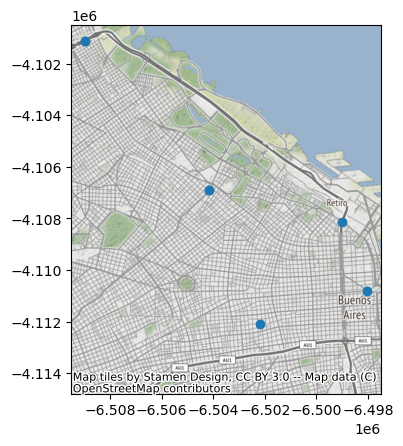

In [58]:
ubicaciones = df_radares.drop_duplicates('geometry')
print(ubicaciones.geometry)

ax = ubicaciones.to_crs(epsg=3857).plot()
cx.add_basemap(ax)

### paradas - con folium

In [178]:
m = folium.Map(location=[-34.6037,-58.3816], zoom_start=11)
folium.Choropleth(poligono_caba, fill_opacity=0.2, line_color=None,).add_to(m)

sub = df_paradas[(df_paradas.linea==152)]
for i, row in sub.iterrows():
    
    color = {'I': 'crimson', 'V': 'blue'}.get(row['sentido'], 'green')
    txt = 'linea:{} \nid {} \nSentido: {}'.format(row['linea'], row['id'], row['sentido'])
    
    folium.Circle(
        radius=10,
        location=(row.latitud, row.longitud),
        popup=txt,
        color=color,
        fill=True).add_to(m)
#folium.Choropleth(sub.geometry).add_to(m)



m


# Analisis 2

## barrios mas frecuentados

In [238]:
# obtener numero linea
df_sube['n_linea'] = df_sube.linea.str.extract(r'([0-9]+)')
df_sube['n_linea'] = df_sube['n_linea'].fillna(0).astype(int)

In [239]:
# agregar barrio a cada parada
def obtener_barrio(punto):
    m = df_barrios.geometry.contains(punto)
    if m.any():
        return df_barrios[m]['barrio'].iloc[0]
    return 'GBA'

df_paradas['barrio'] = df_paradas.geometry.apply(obtener_barrio)
df_paradas.head()

,id,calle,alt,latitud,longitud,geometry,original_column,linea_sentido,linea,sentido,barrio
0,5163,11 DE SEPTIEMBRE DE 1888,2189,-34.5580203,-58.4517506,POINT (-58.45175 -34.55802),col_1,"(15, I)",15,I,BELGRANO
1,8851,11 DE SEPTIEMBRE DE 1888,4650,-34.537759,-58.467365,POINT (-58.46737 -34.53776),col_1,"(28, I)",28,I,NUÑEZ
2,2765,14 DE JULIO,711,-34.5848337,-58.4620871,POINT (-58.46209 -34.58483),col_1,"(127, I)",127,I,VILLA ORTUZAR
3,5466,15 DE NOVIEMBRE DE 1889,1185,-34.6307854,-58.3822511,POINT (-58.38225 -34.63079),col_1,"(9, I)",9,I,CONSTITUCION
4,6465,15 DE NOVIEMBRE DE 1889,1287,-34.6309409,-58.3839737,POINT (-58.38397 -34.63094),col_1,"(91, I)",91,I,CONSTITUCION


In [240]:
# agrupar por linea - solo colectivos amba
df_viajes_linea = df_sube[df_sube['es_amba'] & (df_sube.tipo_transporte=='COLECTIVO')].groupby('n_linea')['cantidad'].mean().reset_index()

# joinear contra paradas
df_mix = df_viajes_linea.merge(df_paradas, left_on='n_linea', right_on='linea', how='inner')
df_mix.head()

,n_linea,cantidad,id,calle,alt,latitud,longitud,geometry,original_column,linea_sentido,linea,sentido,barrio
0,1,4795.993772,930,RIVADAVIA AV.,5434,-34.6210534,-58.4416893,POINT (-58.44169 -34.62105),col_1,"(1, V)",1,V,CABALLITO
1,1,4795.993772,939,RIVADAVIA AV.,5371,-34.6201625,-58.4408517,POINT (-58.44085 -34.62016),col_1,"(1, I)",1,I,CABALLITO
2,1,4795.993772,1006,RIVADAVIA AV.,5677,-34.6221631,-58.4457042,POINT (-58.44570 -34.62216),col_1,"(1, I)",1,I,CABALLITO
3,1,4795.993772,1704,RIVADAVIA AV.,8346,-34.6337486,-58.4811231,POINT (-58.48112 -34.63375),col_1,"(1, V)",1,V,FLORESTA
4,1,4795.993772,1719,RIVADAVIA AV.,7962,-34.6325821,-58.4762232,POINT (-58.47622 -34.63258),col_1,"(1, V)",1,V,FLORESTA


In [246]:
g1 = df_mix.groupby(['barrio', 'linea'], as_index=False)['cantidad'].first()
g2 = g1.groupby('barrio').agg({'cantidad': 'sum', 'linea': 'count'}).rename(columns={'linea': 'lineas'})
g2['densidad'] = g2['cantidad'] / g2['lineas']
g2.sort_values(by='cantidad', ascending=False)
    

,cantidad,lineas,densidad
barrio,,,
SAN NICOLAS,1.125554e+06,57,19746.570169
MONSERRAT,1.055679e+06,52,20301.526848
PALERMO,1.010702e+06,43,23504.686883
BALVANERA,9.530713e+05,49,19450.435037
CABALLITO,9.240591e+05,47,19660.831601
BELGRANO,9.141054e+05,39,23438.599727
CONSTITUCION,8.975969e+05,44,20399.930344
RETIRO,8.690102e+05,46,18891.525940
BARRACAS,8.599798e+05,40,21499.495783


# Forecast Viajes

## setup

In [53]:
df_sube.columns

Index(['dia_transporte', 'nombre_empresa', 'linea', 'amba', 'tipo_transporte',
       'jurisdiccion', 'provincia', 'municipio', 'cantidad', 'dato_preliminar',
       'es_amba', 'fecha', 'es_feriado'],
      dtype='object')

In [183]:
# datos de trabajo
cols = ['tipo_transporte', 'jurisdiccion', 'provincia', 'fecha', 'es_feriado']
data = df_sube[df_sube.es_amba & (df_sube.fecha > '2021-10-01')].groupby(cols, as_index=False)['cantidad'].sum()
for col in ['provincia', 'jurisdiccion']:
    print(data[col].unique())
data['dia_semana'] = data['fecha'].dt.weekday
data['mes'] = data['fecha'].dt.month
data.head()

['BUENOS AIRES' 'JN']
['MUNICIPAL' 'NACIONAL' 'PROVINCIAL']


,tipo_transporte,jurisdiccion,provincia,fecha,es_feriado,cantidad,dia_semana,mes
0,COLECTIVO,MUNICIPAL,BUENOS AIRES,2021-10-02,False,1127221,5,10
1,COLECTIVO,MUNICIPAL,BUENOS AIRES,2021-10-03,False,622214,6,10
2,COLECTIVO,MUNICIPAL,BUENOS AIRES,2021-10-04,False,1917901,0,10
3,COLECTIVO,MUNICIPAL,BUENOS AIRES,2021-10-05,False,2087370,1,10
4,COLECTIVO,MUNICIPAL,BUENOS AIRES,2021-10-06,False,2035106,2,10


In [203]:
# Esqueleto con fecha extendida
import functools

# Fechas
ext_dates = pd.date_range(start=g['fecha'].min(), end='2023-12-31', freq='D')

# Esqueleto con variables basicas
cols = ['tipo_transporte', 'jurisdiccion', 'provincia']
data_ext = pd.DataFrame({'fecha': ext_dates}).merge(data[cols].drop_duplicates(), how='cross')

# Agrego cantidad
cols.append('fecha')
data_ext = data_ext.merge(data[cols + ['cantidad']], on=cols, how='left')
data_ext['cantidad'] = data_ext['cantidad'].fillna(0)

# Agrego campos calculados
data_ext['dia_semana'] = data_ext['fecha'].dt.weekday
data_ext['mes'] = data_ext['fecha'].dt.month
data_ext['es_feriado'] = data_ext['fecha'].isin(holiday_dates)

len(data_ext), len(data)

(3280, 2404)

## modelo

In [189]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error 

In [190]:
# Separate the features and target variable
X = data.drop('cantidad', axis=1)
y = data['cantidad']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [191]:
# Preprocessing pipeline for categorical columns
categorical_preprocessor = Pipeline([
    ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# Column transformer to apply the preprocessing pipeline
catcols = ['tipo_transporte', 'jurisdiccion', 'provincia', 'dia_semana', 'es_feriado', 'mes']

preprocessor = ColumnTransformer([('categorical', categorical_preprocessor, catcols)])

# Random Forest Regressor model pipeline
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Linear Regression model pipeline
lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Train the models
rf_pipeline.fit(X_train, y_train)
lr_pipeline.fit(X_train, y_train)

# Predict on the test set
rf_predictions = rf_pipeline.predict(X_test)
lr_predictions = lr_pipeline.predict(X_test)

# Calculate model accuracies
rf_accuracy = rf_pipeline.score(X_test, y_test)
lr_accuracy = lr_pipeline.score(X_test, y_test)
rf_rmse = mean_squared_error(y_test, rf_predictions)
lr_rmse = mean_squared_error(y_test, lr_predictions)

print('Accuracy Score:', rf_accuracy, '(RF)', lr_accuracy, '(LR)')
print('RMSE Score:', rf_rmse, '(RF)', lr_rmse, '(LR)')


Accuracy Score: 0.9021791820322502 (RF) 0.8580735784406179 (LR)
RMSE Score: 140743346716.84732 (RF) 204201927287.08426 (LR)


In [192]:
param_grid = {
    'regressor__n_estimators': [100, 300],
    'regressor__max_depth': [3, 7],
    'regressor__min_samples_split': [2, 6]
}

grid_search = GridSearchCV(rf_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

fitted_model = grid_search.best_estimator_
best_params = grid_search.best_params_
print("Best Model:", fitted_model)
print("Best Parameters:", best_params)
print('Best Model Accuracy', fitted_model.score(X_test, y_test))


Best Model: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['tipo_transporte',
                                                   'jurisdiccion', 'provincia',
                                                   'dia_semana', 'es_feriado',
                                                   'mes'])])),
                ('regressor',
                 RandomForestRegressor(max_depth=7, min_samples_split=4,
                                       n_estimators=200, random_state=42))])
Best Parameters: {'regressor__max_depth': 7, 'regressor__min_samples_split': 4, 'regressor__n_estimators': 200}
Best Model Accur

## aplicar resultado modelo a dataset

In [204]:
best_model = rf_pipeline
data['cantidad_pred'] = best_model.predict(data.drop(['cantidad'], axis=1)).astype(int)
data_ext['cantidad_pred'] = best_model.predict(data_ext.drop(['cantidad'], axis=1)).astype(int)

data.head(3)

,tipo_transporte,jurisdiccion,provincia,fecha,es_feriado,cantidad,dia_semana,mes,cantidad_pred
0,COLECTIVO,MUNICIPAL,BUENOS AIRES,2021-10-02,False,1127221,5,10,1289495
1,COLECTIVO,MUNICIPAL,BUENOS AIRES,2021-10-03,False,622214,6,10,679467
2,COLECTIVO,MUNICIPAL,BUENOS AIRES,2021-10-04,False,1917901,0,10,1652534


## output tren

In [207]:
df_viajes_tren = data_ext[(data_ext['tipo_transporte']=='TREN') & (data_ext['fecha'] > '2022-01-01')]
print(df_viajes_tren.head(2))

         fecha tipo_transporte jurisdiccion provincia  cantidad  dia_semana  \
367 2022-01-02            TREN     NACIONAL        JN  164887.0           6   
371 2022-01-03            TREN     NACIONAL        JN  732406.0           0   

     mes  es_feriado  cantidad_pred  
367    1       False         197987  
371    1       False         802040  


<Axes: xlabel='fecha', ylabel='cantidad_pred'>

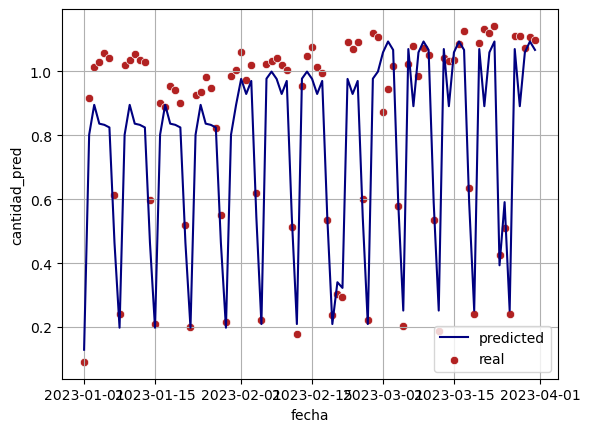

In [212]:
fig, ax = plt.subplots()
ax.grid()
g = df_viajes_tren[(df_viajes_tren['fecha'] < '2023-04-01') & (df_viajes_tren['fecha'] >= '2023-01-01')]
x = g['fecha']
y1 = g['cantidad'] / 1e6
y2 = g['cantidad_pred'] / 1e6
sns.lineplot(ax=ax,x=x, y=y2, color='navy', label='predicted')
sns.scatterplot(ax=ax, x=x, y=y1, color='firebrick', label='real')

Text(0, 0.5, 'Viajes en tren totales [Millones]')

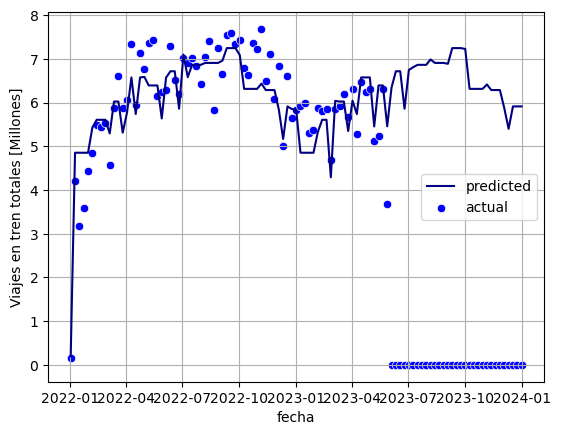

In [214]:
# forecast a futuro
g = df_viajes_tren.groupby(pd.Grouper(key='fecha', freq='1W'))[['cantidad', 'cantidad_pred']].sum()
g /= 1000000
g = g.reset_index()

fig, ax = plt.subplots()
ax.grid()
sns.lineplot(ax=ax, data=g, x='fecha', y='cantidad_pred', label='predicted', color='navy')
sns.scatterplot(ax=ax, data=g, x='fecha', y='cantidad', label='actual', color='blue')
ax.set_ylabel('Viajes en tren totales [Millones]')
#fig.show()

## Output por tipo transporte

In [215]:
g = data_ext.groupby(['tipo_transporte', pd.Grouper(key='fecha', freq='1W')])[['cantidad', 'cantidad_pred']].sum()
g = g.reset_index()
g['cantidad'] /= 1000000
g['cantidad_pred'] /= 1000000

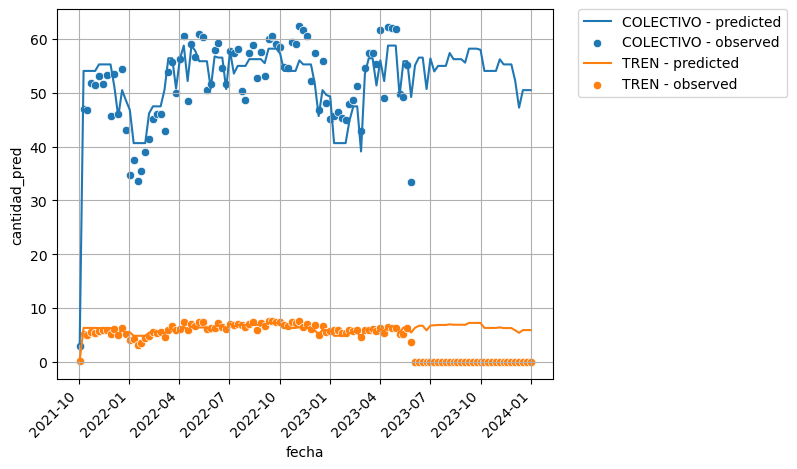

In [223]:
fig, ax = plt.subplots()
ax.grid()

for t in g['tipo_transporte'].unique():
    sns.lineplot(ax=ax, data=g[g['tipo_transporte']==t], x='fecha', y='cantidad_pred', label=f'{t} - predicted')
    sns.scatterplot(ax=ax, data=g[g['tipo_transporte']==t], x='fecha', y='cantidad', label=f'{t} - observed')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xticks(rotation=45, ha='right')
plt.show()

## output colectivo por tipo

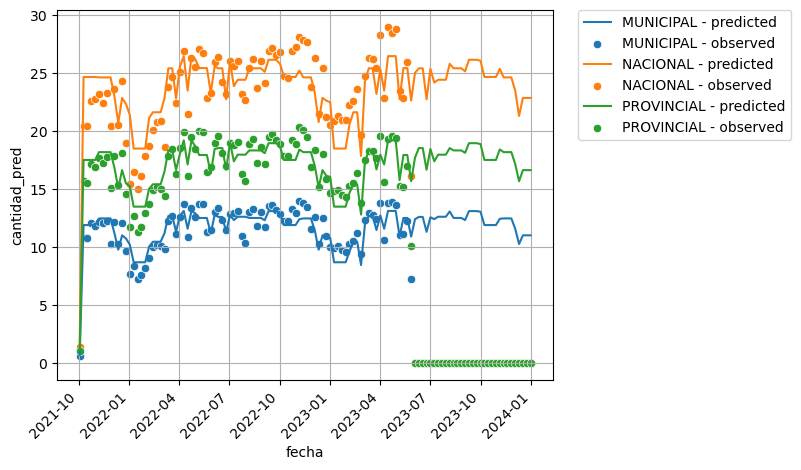

In [224]:
g = data_ext[data_ext['tipo_transporte'] == 'COLECTIVO'].groupby(['jurisdiccion', pd.Grouper(key='fecha', freq='1W')])[['cantidad', 'cantidad_pred']].sum()
g = g.reset_index()
g['cantidad'] /= 1000000
g['cantidad_pred'] /= 1000000

fig, ax = plt.subplots()
ax.grid()

for t in g['jurisdiccion'].unique():
    sns.lineplot(ax=ax, data=g[g['jurisdiccion']==t], x='fecha', y='cantidad_pred', label=f'{t} - predicted')
    sns.scatterplot(ax=ax, data=g[g['jurisdiccion']==t], x='fecha', y='cantidad', label=f'{t} - observed')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xticks(rotation=45, ha='right')
plt.show()